In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import *
from collections import defaultdict
import graphlib
import statistics

from matplotlib import pyplot as plt
import timeit
import igraph
import functools

import graphlib2


In [2]:
T = TypeVar("T", bound=Hashable)

Graph = Dict[T, List[T]]


In [3]:
@functools.cache
def get_linear_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree(n, 1)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

@functools.cache
def get_branched_graph(n: int) -> Graph[int]:
    g = igraph.Graph.Tree_Game(n, directed=True)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

In [4]:
def run(
    t: Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]],
    graph: Graph[T],
) -> None:
    to_remove = t.get_ready()
    while t.is_active():
        t.done(*to_remove)
        to_remove = t.get_ready()


def setup_rust(graph: Graph[T]) -> graphlib2.TopologicalSorter[T]:
    t: graphlib2.TopologicalSorter[T] = graphlib2.TopologicalSorter()
    for node, children in graph.items():
        t.add(node, *children)
    t.prepare()
    return t


def setup_python(graph: Graph[T]) -> graphlib.TopologicalSorter[T]:
    t: graphlib.TopologicalSorter[T] = graphlib.TopologicalSorter(graph)
    t.prepare()
    return t


def copy_rust(ts: graphlib2.TopologicalSorter[T], graph: Graph[T]) -> None:
    ts.copy()


def copy_python(ts: graphlib.TopologicalSorter[T], graph: Graph[T]) -> None:
    setup_python(graph)


## Time individual methods

These benchmarks are not a real Apples to Apples comparison since the methods do different amounts of work internally (even if it adds up the same total amount).

In [5]:
@dataclass
class MethodTimings:
    is_active: List[float] = field(default_factory=list)
    done: List[float] = field(default_factory=list)
    get_ready: List[float] = field(default_factory=list)


def bench_methods(ts: Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]]) -> MethodTimings:
    timings = MethodTimings()
    while True:
        start = timeit.default_timer()
        is_active = ts.is_active()
        timings.is_active.append(timeit.default_timer()-start)
        if not is_active:
            break
        start = timeit.default_timer()
        ready = ts.get_ready()
        timings.get_ready.append(timeit.default_timer()-start)
        start = timeit.default_timer()
        ts.done(*ready)
        timings.done.append(timeit.default_timer()-start)
    return timings

In [6]:
def plot_method_timings(
    upper: int,
    samples: int,
    graph_factory: Callable[[int], Graph[T]],
    lower: int = 0,
    loops: int = 10,
) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    python_is_active: List[float] = []
    python_get_ready: List[float] = []
    python_done: List[float] = []
    rust_is_active: List[float] = []
    rust_get_ready: List[float] = []
    rust_done: List[float] = []
    for n in x:
        py: List[MethodTimings] = []
        rust: List[MethodTimings] = []
        graph = graph_factory(n)
        for _ in range(loops):
            py.append(bench_methods(setup_python(graph)))
            rust.append(bench_methods(setup_rust(graph)))
        python_is_active.append(float(statistics.median([sum(t.is_active) for t in py])))
        python_get_ready.append(float(statistics.median([sum(t.get_ready) for t in py])))
        python_done.append(float(statistics.median([sum(t.done) for t in py])))
        rust_is_active.append(float(statistics.median([sum(t.is_active) for t in rust])))
        rust_get_ready.append(float(statistics.median([sum(t.get_ready) for t in rust])))
        rust_done.append(float(statistics.median([sum(t.done) for t in rust])))
    fig, (is_active_ax, get_ready_ax, done_ax) = plt.subplots(1, 3)
    fig.text(0.5, 0.04, "V (number of vertices)", ha='center')
    fig.text(0.04, 0.5, "is_active()", va='center', rotation='vertical')
    is_active_ax.plot(x, python_is_active, label="python")
    is_active_ax.plot(x, rust_is_active, label="rust")
    is_active_ax.legend()
    get_ready_ax.plot(x, python_get_ready, label="python")
    get_ready_ax.plot(x, rust_get_ready, label="rust")
    get_ready_ax.legend()
    done_ax.plot(x, python_done, label="python")
    done_ax.plot(x, rust_done, label="rust")
    done_ax.legend()


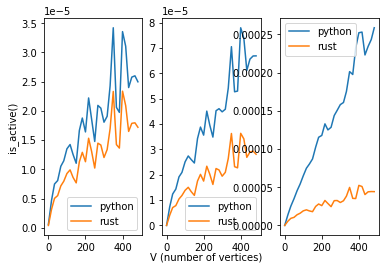

In [7]:
plot_method_timings(upper=500, samples=30, loops=20, graph_factory=get_branched_graph)

## Execution time benchmarks

Benchmarks that test how long it takes to execute the graph assuming dependencies execute instantly.
This does not count the time required to create the graph or prepare the toplogical sorter.

In [8]:
@dataclass
class Target(Generic[T]):
    rust: Callable[[Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]], Graph[T]], None]
    python: Callable[[Union[graphlib2.TopologicalSorter[T], graphlib.TopologicalSorter[T]], Graph[T]], None]


def plot(
    upper: int,
    samples: int,
    graph_factory: Callable[[int], Graph[T]],
    target: Target[T],
    lower: int = 0,
    loops: int = 10,
) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    y_python: List[float] = []
    y_rust: List[float] = []
    for n in x:
        p: List[float] = []
        r: List[float] = []
        graph = graph_factory(n)
        for _ in range(loops):
            ts = setup_python(graph)
            start = timeit.default_timer()
            target.python(ts, graph)
            p.append(timeit.default_timer()-start)
            ts = setup_rust(graph)
            start = timeit.default_timer()
            target.rust(ts, graph)
            r.append(timeit.default_timer()-start)
        y_python.append(statistics.median(p))
        y_rust.append(statistics.median(r))
    plt.plot(x, y_python, label="python")
    plt.plot(x, y_rust, label="rust")
    plt.legend(loc="upper left")
    plt.xlabel("V (number of vertices)")
    plt.ylabel("Execution time (s)")

For a linear graph (`{"A": ["B"], "B": ["C"], "C": ["D"]}`):

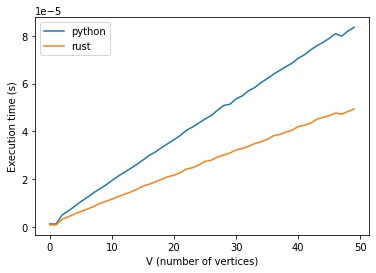

In [9]:
plot(upper=50, samples=50, loops=30, graph_factory=get_linear_graph, target=Target(run, run))

For a randomized branched graph (`{"A": ["B", "C"], "B": ["C"], "C": ["D", "E"]}`):

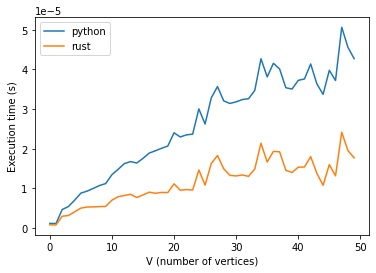

In [10]:
plot(upper=50, samples=50, loops=30, graph_factory=get_branched_graph, target=Target(run, run))

Same benchmarks for much larger graphs

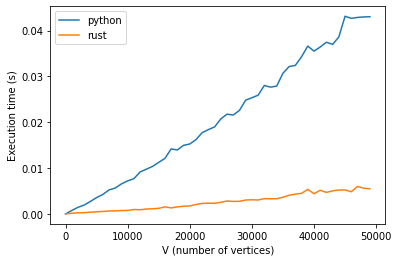

In [11]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_branched_graph, target=Target(run, run))

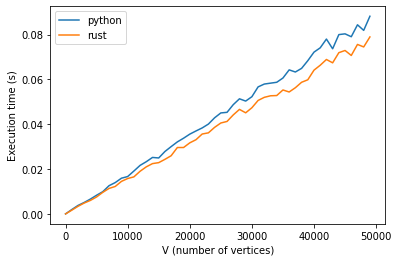

In [12]:
plot(upper=50_000, samples=50, loops=7, graph_factory=get_linear_graph, target=Target(run, run))

## Copy benchmarks

Measure copying a `ToplogicalSorter` instance.
The standard library does not have a `copy()` method, so we just re-create the `ToplogicalSorter`, which is inefficient but is the only option available.

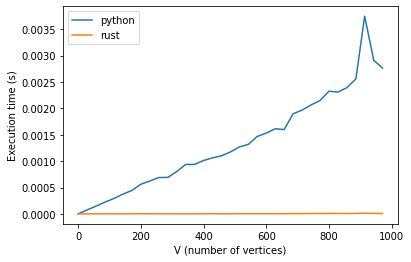

In [14]:
target: Target[T] = Target(rust=copy_rust, python=copy_python)
plot(upper=1_000, samples=35, loops=15, graph_factory=get_branched_graph, target=target)

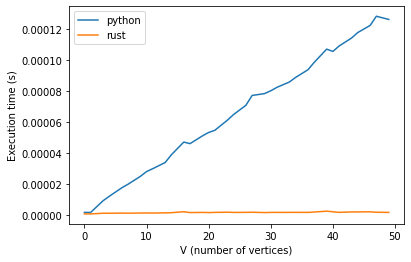

In [15]:
plot(upper=50, samples=35, loops=15, graph_factory=get_branched_graph, target=target)

Time copying a `graphlib2.ToplogicalSorter` so it can be compared against itself

In [17]:
%%timeit ts = setup_rust(get_branched_graph(100))
ts.copy()

813 ns ± 7.75 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
